In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

from qiskit_experiments.test.pulse_backend import SingleTransmonTestBackend
from qiskit_experiments.calibration_management.calibrations import Calibrations
from qiskit_experiments.calibration_management.basis_gate_library import FixedFrequencyTransmon
from qiskit_experiments.library import Rabi, EFRabi
from qiskit import pulse, schedule
from qiskit.circuit import Parameter, QuantumCircuit, Gate, Delay
import warnings

from qiskit_ibm_catalog import QiskitFunctionsCatalog
warnings.filterwarnings('ignore')
%matplotlib inline

# QiskitFunctionsCatalog.save_account(token="0a5a83b05b516d33ebd5799df1100b1be1f74091b8982f8c583dfba8e3aac0a337d02fa40a79b1ade2970d93f411cb368bdd2b6fe80a4912db17ed93dedc4d51",overwrite=True)
# catalog = QiskitFunctionsCatalog()





In [6]:
qubit = 0
backend = SingleTransmonTestBackend(noise=False)

backend_defaults = backend.defaults()
ge_freq = backend_defaults.qubit_freq_est[qubit] 
dt = backend.dt
print(f"Qubit has an estimated g-e frequency of {ge_freq*1e-9} GHz.")
print(f"Qubit has an estimated dt of {dt*1e9} ns.")
anharmonicity = backend.anharmonicity
ef_freq = ge_freq + anharmonicity
print(f"Qubit has an estimated anharmonicity of {anharmonicity*1e-9} GHz.")
print(f"Qubit has an estimated e-f frequency of {ef_freq*1e-9} GHz.")

Qubit has an estimated g-e frequency of 5.0 GHz.
Qubit has an estimated dt of 0.10000000000000002 ns.
Qubit has an estimated anharmonicity of -0.25 GHz.
Qubit has an estimated e-f frequency of 4.75 GHz.


Here we will study the distribution of IQ measurements of the ground and excited states, this could be interesting to stablish some selection methods in the counting translation of the readout. Also we want to learn about how the qubit readout works and its precision. 

# g-state

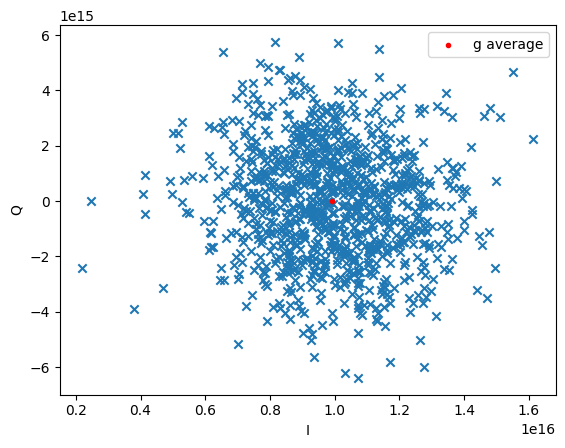

In [2]:
num_shots = 2**10

gqc = QuantumCircuit(1, 1)
gqc.measure(0, 0)
gjob = backend.run(gqc,meas_level=1,meas_return='single',shots=num_shots)
gresults = gjob.result()
gpoints = gresults.get_memory(0)
greal = [np.real(gpoints[i]) for i in range(len(gpoints))]
gimag = [np.imag(gpoints[i]) for i in range(len(gpoints))]
greal_mean = np.mean(greal)
gimag_mean = np.mean(gimag)

plt.scatter(greal,gimag,marker='x')
plt.scatter(greal_mean,gimag_mean,marker='.',color='red',label='g average')
plt.legend()
plt.xlabel('I')
plt.ylabel('Q')
plt.show()

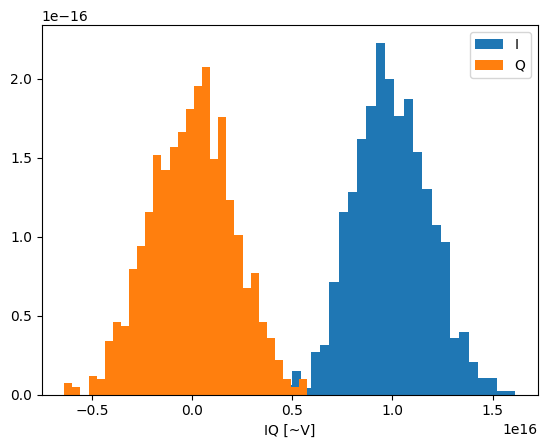

In [3]:
I = [greal[i][0] for i in range(len(greal))]
Q = [gimag[i][0] for i in range(len(gimag))]
plt.hist(I,density=True,bins=30, label='I')
plt.hist(Q,density=True,bins=30, label='Q')
plt.xlabel('IQ [~V]')
plt.legend()
plt.show()

We will normalise the IQ data

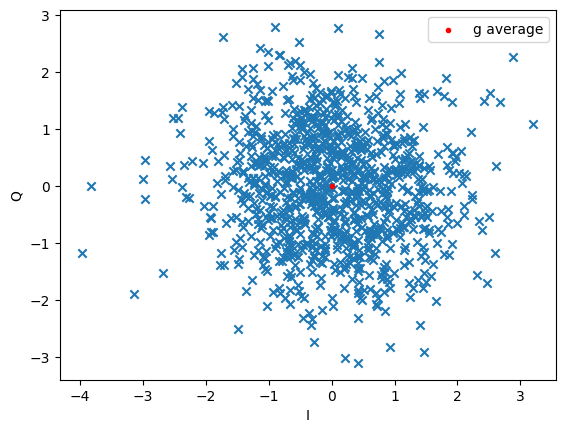

In [4]:
greal_sd = np.var(greal)**(1/2)
gimag_sd = np.var(gimag)**(1/2)

greal_norm = (greal - greal_mean)/greal_sd
gimag_norm = (gimag - gimag_mean)/gimag_sd

plt.scatter(greal_norm,gimag_norm,marker='x')
plt.scatter(0,0,marker='.',color='red',label='g average')
plt.legend()
plt.xlabel('I')
plt.ylabel('Q')
plt.show()

Let's assume, by the central limit theorem, that the I dn Q random variables follow a normal distribution for large enough samples. We can study the distribution of the radius (from the origin) squared, as it shall follow a chi-squared distribution with k=2 freedom degrees. Let's obtain the radius:

In [5]:
grho2 = greal_norm**2 + gimag_norm**2
grho2_mean = np.mean(grho2)
grho2_sd = np.var(grho2)**(1/2)
print('g-state rho^2 normalised mean: '+str(grho2_mean))
print('g-state rho^2 normalised var: '+str(grho2_sd**2))

g-state rho^2 normalised mean: 2.0
g-state rho^2 normalised var: 4.061943895413777


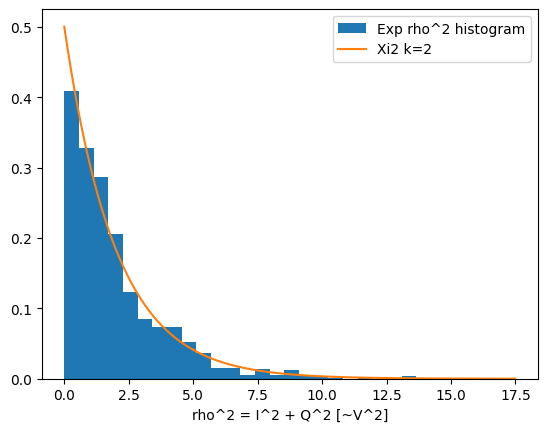

In [6]:
xx = np.arange(0,17.5,0.01)
yxi2 = (1/2)*np.exp(-xx/2)
plt.hist(grho2,density=True,bins=30, label='Exp rho^2 histogram')
plt.plot(xx,yxi2, label='Xi2 k=2')
plt.xlabel('rho^2 = I^2 + Q^2 [~V^2]')
plt.legend()
plt.show()

We can develop a method to decide, with some level of confidence, if the IQ point measured corresponds to the g-state or not. 

In [7]:
def Fxi2_2(x_):
    return 1-np.exp(-x_/2)

In [8]:
def gstate_eval(value, alpha):
    value_real = (np.real(value)-greal_mean)/greal_sd
    value_imag = (np.imag(value)-gimag_mean)/gimag_sd
    value_rho2 = value_real**2 + value_imag**2
    if Fxi2_2(value_rho2) <= (1-alpha):
        return True
    else:
        return False

In [9]:
gstate_eval((0.2e15+1j*0), 0.00001)

False

# e-state

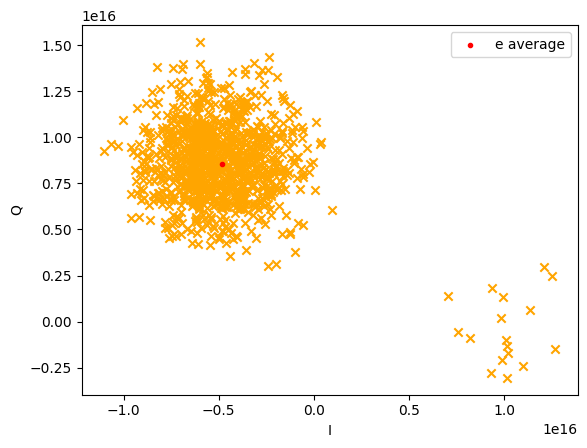

In [10]:
num_shots = 2**10

eqc = QuantumCircuit(1, 1)
eqc.x(0)
eqc.measure(0, 0)
ejob = backend.run(eqc,meas_level=1,meas_return='single',shots=num_shots)
eresults = ejob.result()
epoints = eresults.get_memory(0)
ereal = [np.real(epoints[i]) for i in range(len(epoints))]
eimag = [np.imag(epoints[i]) for i in range(len(epoints))]
ereal_mean = np.mean(ereal)
eimag_mean = np.mean(eimag)

plt.scatter(ereal,eimag,marker='x', color='orange')
plt.scatter(ereal_mean,eimag_mean,marker='.',color='red',label='e average')
plt.legend()
plt.xlabel('I')
plt.ylabel('Q')
plt.show()

We need to normalise the data and remove the g-state points with some confidence level (0.001)

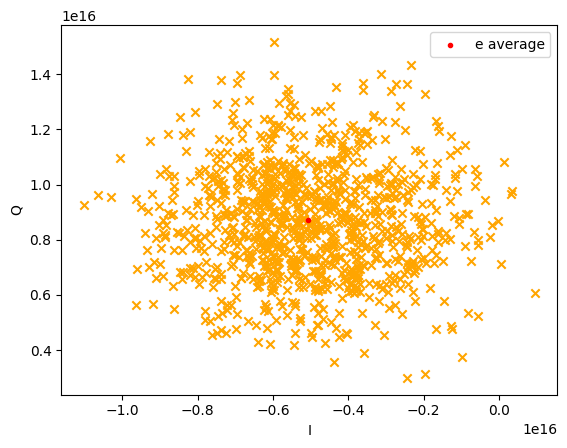

In [11]:
new_epoints = []

for i in range(len(epoints)):
    if gstate_eval(epoints[i], 0.001) == False:
        new_epoints.append(epoints[i])

ereal = [np.real(new_epoints[i]) for i in range(len(new_epoints))]
eimag = [np.imag(new_epoints[i]) for i in range(len(new_epoints))]
ereal_mean = np.mean(ereal)
eimag_mean = np.mean(eimag)

plt.scatter(ereal,eimag,marker='x', color='orange')
plt.scatter(ereal_mean,eimag_mean,marker='.',color='red',label='e average')
plt.legend()
plt.xlabel('I')
plt.ylabel('Q')
plt.show()

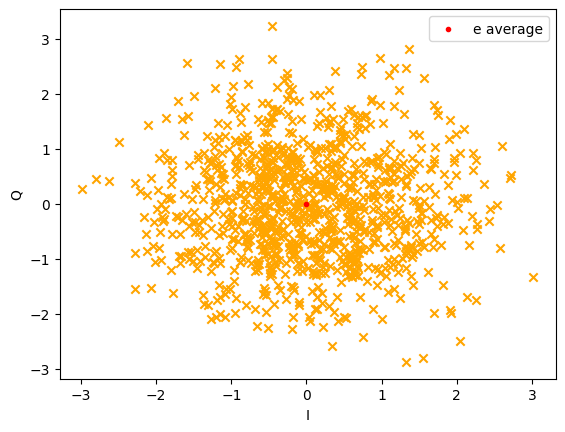

In [12]:
ereal_sd = np.var(ereal)**(1/2)
eimag_sd = np.var(eimag)**(1/2)

ereal_norm = (ereal - ereal_mean)/ereal_sd
eimag_norm = (eimag - eimag_mean)/eimag_sd

plt.scatter(ereal_norm,eimag_norm,marker='x', color='orange')
plt.scatter(0,0,marker='.',color='red',label='e average')
plt.legend()
plt.xlabel('I')
plt.ylabel('Q')
plt.show()

In [13]:
def estate_eval(value, alpha):
    value_real = (np.real(value)-ereal_mean)/ereal_sd
    value_imag = (np.imag(value)-eimag_mean)/eimag_sd
    value_rho2 = value_real**2 + value_imag**2
    if Fxi2_2(value_rho2) <= (1-alpha):
        return True
    else:
        return False

In [14]:
estate_eval((1e15+1j*0), 0.001)

False

# f-state

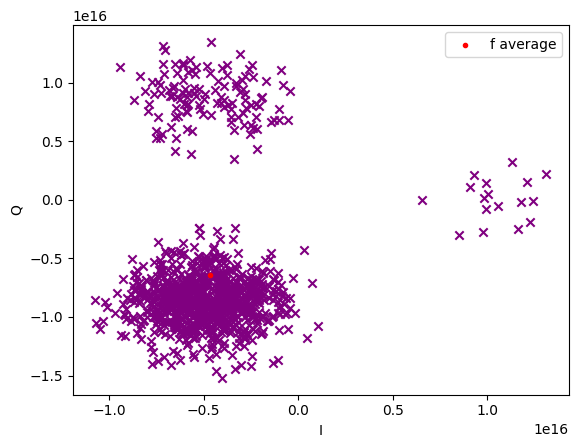

In [15]:
num_shots = 2**10
drive_amp = 0.013453403433238085 #from transmon_cals notebook

#from calibration reference
lcm = 16
granularity = 16
def get_closest_multiple_of(value, base_number):
    return int(value + base_number/2) - (int(value + base_number/2) % base_number)
def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)
def get_dt_from(sec):
    return get_closest_multiple_of(sec/dt, lcm)
    
drive_sigma_sec = 0.015e-6 
drive_duration_sec = drive_sigma_sec * 8 


with pulse.build(backend=backend, default_alignment='sequential', name='ef_pulse') as ef_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.DriveChannel(qubit)
    pulse.set_frequency(ef_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,amp=drive_amp,sigma=drive_sigma,name='Rabi Pulse'), drive_chan)

ef_gate = Gate("ef", 1, [drive_amp])

fqc = QuantumCircuit(1, 1)
fqc.x(0)
fqc.append(ef_gate, [0])
fqc.measure(0, 0)
fqc.add_calibration(ef_gate, (0,), ef_pulse, [drive_amp])
fjob = backend.run(fqc,meas_level=1,meas_return='single',shots=num_shots)
fresults = fjob.result()
fpoints = fresults.get_memory(0)

freal = [np.real(fpoints[i]) for i in range(len(fpoints))]
fimag = [np.imag(fpoints[i]) for i in range(len(fpoints))]

freal_mean = np.mean(freal)
fimag_mean = np.mean(fimag)


plt.scatter(freal,fimag,marker='x', color='purple')
plt.scatter(freal_mean,fimag_mean,marker='.',color='red',label='f average')
plt.legend()
plt.xlabel('I')
plt.ylabel('Q')
plt.show()

We need to remove the g-state and e-state points.

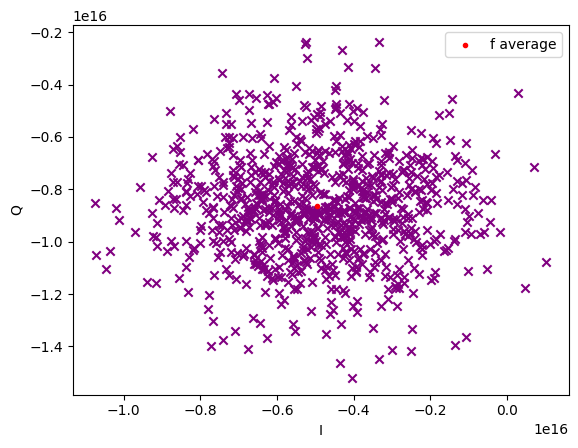

In [16]:
new_fpoints = []

for i in range(len(fpoints)):
    if gstate_eval(fpoints[i], 0.001) == False and estate_eval(fpoints[i], 0.001) == False:
        new_fpoints.append(fpoints[i])

freal = [np.real(new_fpoints[i]) for i in range(len(new_fpoints))]
fimag = [np.imag(new_fpoints[i]) for i in range(len(new_fpoints))]
freal_mean = np.mean(freal)
fimag_mean = np.mean(fimag)

plt.scatter(freal,fimag,marker='x', color='purple')
plt.scatter(freal_mean,fimag_mean,marker='.',color='red',label='f average')
plt.legend()
plt.xlabel('I')
plt.ylabel('Q')
plt.show()

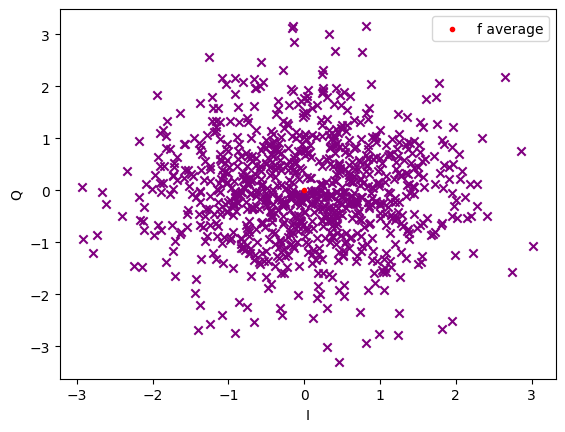

In [17]:
freal_sd = np.var(freal)**(1/2)
fimag_sd = np.var(fimag)**(1/2)

freal_norm = (freal - freal_mean)/freal_sd
fimag_norm = (fimag - fimag_mean)/fimag_sd

plt.scatter(freal_norm,fimag_norm,marker='x', color='purple')
plt.scatter(0,0,marker='.',color='red',label='f average')
plt.legend()
plt.xlabel('I')
plt.ylabel('Q')
plt.show()

In [18]:
def fstate_eval(value, alpha):
    value_real = (np.real(value)-freal_mean)/freal_sd
    value_imag = (np.imag(value)-fimag_mean)/fimag_sd
    value_rho2 = value_real**2 + value_imag**2
    if Fxi2_2(value_rho2) <= (1-alpha):
        return True
    else:
        return False

In [19]:
fstate_eval((1e15+1j*0), 0.001)

False

# Método de clasificación
Consiste en, dado un punto arbitrario del plano IQ, asignarle uno de los 3 estados del qubit. El nivel de confianza mínimo será 0.001 y en las regiones comunes se decidirá por cuál es el más probable (mayor valor de la función de distribución de rho2)

In [20]:
def state_eval(value_):
    gvalue_rho2 = ((np.real(value_)-greal_mean)/greal_sd)**2 + ((np.imag(value_)-gimag_mean)/gimag_sd)**2
    evalue_rho2 = ((np.real(value_)-ereal_mean)/ereal_sd)**2 + ((np.imag(value_)-eimag_mean)/eimag_sd)**2
    fvalue_rho2 = ((np.real(value_)-freal_mean)/freal_sd)**2 + ((np.imag(value_)-fimag_mean)/fimag_sd)**2

    gF = Fxi2_2(gvalue_rho2)
    eF = Fxi2_2(evalue_rho2)
    fF = Fxi2_2(fvalue_rho2)
    F = [gF,eF,fF]

    return F.index(min(F))

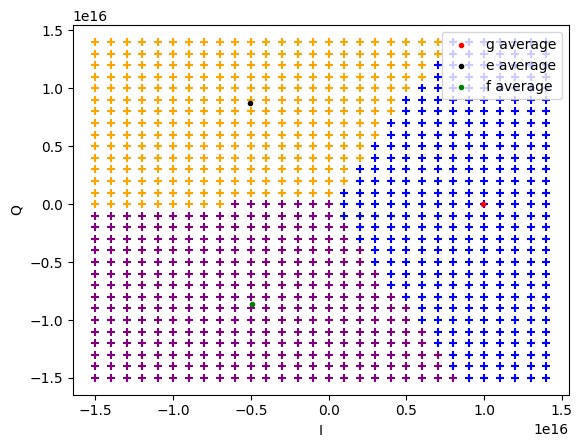

In [21]:
xx = np.arange(-1.5e16,1.5e16,1e15)
yy = np.arange(-1.5e16,1.5e16,1e15)
colores = {0:'blue', 1:'orange', 2:'purple',-1:'white'}
for i in range(len(xx)):
    for j in range(len(yy)):
        ijstate = state_eval(xx[i]+1j*yy[j])
        plt.scatter(xx[i],yy[j], color = colores[ijstate], marker='+')
plt.scatter(greal_mean,gimag_mean,marker='.',color='red',label='g average')
plt.scatter(ereal_mean,eimag_mean,marker='.',color='black',label='e average')
plt.scatter(freal_mean,fimag_mean,marker='.',color='green',label='f average')
plt.xlabel('I')
plt.ylabel('Q')
plt.legend()
plt.show()

# state_translation class

In [22]:
# class state_translation():
#     def __init__(self,ge_freq,ef_freq,ge_amp,ef_amp):

In [23]:
print(greal_mean)
print(greal_sd)
print(gimag_mean)
print(gimag_sd)

9902319823705892.0
1943983653606189.8
-10314795690997.14
2059784851061343.0


In [24]:
print(ereal_mean)
print(ereal_sd)
print(eimag_mean)
print(eimag_sd)

-5073534126236443.0
1994162915723920.0
8717570366322792.0
1992881782518715.8


In [25]:
print(freal_mean)
print(freal_sd)
print(fimag_mean)
print(fimag_sd)

-4944308428453590.0
1976717939696197.2
-8652950677803876.0
1985774624875476.2
